Imports and Setup

In [1]:
# Import necessary libraries
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import BinaryAccuracy
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from skimage import io, transform
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import keras_tuner as kt
from keras_tuner import Hyperband
from keras_tuner import HyperParameters

Unique Identifier Extraction To Match Images with Respective Masks

In [2]:
# This function is to extract the unique identifier from the filename so the pairing 
# of images and their respective corresponding masks takes plake seaminglessly.
def extract_id(filename):
    """
    Extracts the unique identifier from the filename.
    Assumes the identifier is between 'cxrimage_' and '.png' or 'cxrmask_' and '.jpeg'.
    """
    if 'cxrimage_' in filename:
        return filename.split('cxrimage_')[1].split('.png')[0]
    elif 'cxrmask_' in filename:
        return filename.split('cxrmask_')[1].split('.jpeg')[0]
    return None

Data Loading and Preprocessing

In [3]:
# Data Preprocessing
def load_and_preprocess_image(image_path, mask_path, target_size=(128, 128)):
    """
    Load and preprocess a single image and its corresponding mask.
    """
    try:
        # Load the image and mask.
        image = io.imread(image_path, as_gray=True)
        mask = io.imread(mask_path, as_gray=True)
        
        # Resize to target size.
        image = transform.resize(image, target_size, mode='constant', preserve_range=True)
        mask = transform.resize(mask, target_size, mode='constant', preserve_range=True)
        
        # Normalize images.
        image = image / 255.0
        mask = mask / 255.0

        # Ensure the mask has a single channel.
        mask = np.expand_dims(mask, axis=-1)  
        
        return image, mask
    except Exception as e:
        print(f"Error loading images {image_path} and {mask_path}: {e}")
        return None, None

In [4]:
# Load data.
def load_data_from_directories(image_dir, mask_dir, target_size=(128, 128)):
    """
    Load and preprocess images and masks from given directories.
    Pairs images with masks based on their unique identifier.
    """
    image_filenames = [f for f in os.listdir(image_dir) if f.endswith('.png')]
    mask_filenames = [f for f in os.listdir(mask_dir) if f.endswith('.jpeg')]
    
    # Create a dictionary to map identifiers to mask filenames.
    mask_dict = {}
    for mask_filename in mask_filenames:
        mask_id = extract_id(mask_filename)
        if mask_id:
            mask_dict[mask_id] = os.path.join(mask_dir, mask_filename)

    # This is to create an empty list for the images and 
    # another for the masks to store the loaded data.
    images = []
    masks = []
    
    # This print statement is to help with debugging to ensure the data are being loaded.
    print("Loading data...")
    
    # Iterate over image files and find corresponding masks.
    for img_filename in image_filenames:
        image_id = extract_id(img_filename)
        if image_id:
            image_path = os.path.join(image_dir, img_filename)

            # Get corresponding mask path.
            mask_path = mask_dict.get(image_id)  
            
            if mask_path:
                
                # Load and preprocess the image and mask.
                image, mask = load_and_preprocess_image(image_path, mask_path, target_size)
                if image is not None and mask is not None:
                    images.append(image)
                    masks.append(mask)
                else:
                    print(f"Skipping {image_path} and {mask_path} due to loading error.")
            else:
                print(f"No corresponding mask found for {image_path}.")
    
    print(f"Loaded {len(images)} images and masks.")
    return np.array(images), np.array(masks)

Metrics

In [5]:
# This the dice coefficient function definition.
def dice_coefficient(y_true, y_pred):
    smooth = 1e-6
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

In [6]:
# This is the Intersection over Union function definition.
def iou(y_true, y_pred):
    smooth = 1e-6
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    union = K.sum(y_true_f) + K.sum(y_pred_f) - intersection
    return (intersection + smooth) / (union + smooth)

In [7]:
# This the sensitivity function definition.
def sensitivity(y_true, y_pred):
    true_positive = tf.keras.backend.sum(y_true * y_pred)
    possible_positive = tf.keras.backend.sum(y_true)
    return true_positive / (possible_positive + tf.keras.backend.epsilon())

Model Definition with Tunable Hyperparameters

In [8]:
# This is to define the learning rate schedule function.
def get_lr_schedule(strategy='exponential', initial_lr=1e-4, decay_rate=.96, decay_steps=1000, \
                    end_learning_rate=1e-6, power=1.0, patience=5):
    """
    Custom learning rate schedule function.
    """
    if strategy =='exponential':
        return tf.keras.callbacks.LearningRateScheduler(lambda epoch:initial_lr*decay_rate**(epoch/decay_steps))
    elif strategy== 'polynomial':
        return tf.keras.callbacks.LearningRateScheduler(tf.keras.experimental.CosineDecayRestarts(\
            initial_learning_rate=initial_lr, first_decay_steps=decay_steps, t_mul=2.0, m_mul=.9,\
                alpha=end_learning_rate/initial_lr))
    elif strategy=='plateau':
        return tf.keras.callbacks.ReducedLROnPlateau(monitor='val_loss', factor=.5,\
                                                     patience=patience,verbose=1, min_lr=1e-6)
    else:
        raise ValueError("Unsupported strategy. Choose from 'exponential', 'polynomial',or 'plateau'.",)

In [9]:
# This is to define the U-Net Model.
def unet_model(hp):
    """
    Build a U-Net model with hyperparameters for tuning.
    """
    
    # Retrieve hyperparameters with default values
    filters1 = hp.Int('filters1', min_value=32, max_value=128, step=32, default=64)
    filters2 = hp.Int('filters2', min_value=64, max_value=256, step=64, default=128)
    filters3 = hp.Int('filters3', min_value=128, max_value=512, step=128, default=256)
    filters4 = hp.Int('filters4', min_value=256, max_value=1024, step=256, default=512)
    filters5 = hp.Int('filters5', min_value=128, max_value=512, step=128, default=256)
    filters6 = hp.Int('filters6', min_value=64, max_value=256, step=64, default=128)
    filters7 = hp.Int('filters7', min_value=32, max_value=128, step=32, default=64)
    learning_rate = hp.Float('learning_rate', min_value=1e-5, max_value=1e-2, sampling='LOG', default=1e-4)
    dropout_rate = hp.Float('dropout_rate', min_value=0, max_value=0.5, default=0.5)

    inputs = Input(shape=(128, 128, 1))
    
    # Encoder
    conv1 = Conv2D(filters1, (3, 3), activation='relu', padding='same')(inputs)
    
    # Batch Normalization
    conv1 = BatchNormalization()(conv1)  
    conv1 = Conv2D(filters1, (3, 3), activation='relu', padding='same')(conv1)
      
    # Batch Normalizationconv1 = BatchNormalization()(conv1)  
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    # Dropout
    pool1 = Dropout(dropout_rate)(pool1)  
    
    conv2 = Conv2D(filters2, (3, 3), activation='relu', padding='same')(pool1)
    
    # Batch Normalization
    conv2 = BatchNormalization()(conv2)  
    conv2 = Conv2D(filters2, (3, 3), activation='relu', padding='same')(conv2)
    
    # Batch Normalization
    conv2 = BatchNormalization()(conv2)  
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    # Dropout
    pool2 = Dropout(dropout_rate)(pool2)  
    
    conv3 = Conv2D(filters3, (3, 3), activation='relu', padding='same')(pool2)
    
    # Batch Normalization
    conv3 = BatchNormalization()(conv3)  
    conv3 = Conv2D(filters3, (3, 3), activation='relu', padding='same')(conv3)
    
    # Batch Normalization
    conv3 = BatchNormalization()(conv3)  
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    # Dropout
    pool3 = Dropout(dropout_rate)(pool3)  
    
    # Bottleneck
    conv4 = Conv2D(filters4, (3, 3), activation='relu', padding='same')(pool3)
    
    # Batch Normalization
    conv4 = BatchNormalization()(conv4)  
    conv4 = Conv2D(filters4, (3, 3), activation='relu', padding='same')(conv4)
    
    # Batch Normalization
    conv4 = BatchNormalization()(conv4)  
    
    # Decoder
    up5 = UpSampling2D(size=(2, 2))(conv4)
    up5 = concatenate([up5, conv3], axis=3)
    conv5 = Conv2D(filters5, (3, 3), activation='relu', padding='same')(up5)
    
    # Batch Normalization
    conv5 = BatchNormalization()(conv5)  
    conv5 = Conv2D(filters5, (3, 3), activation='relu', padding='same')(conv5)
    
    # Batch Normalization
    conv5 = BatchNormalization()(conv5)  
    
    up6 = UpSampling2D(size=(2, 2))(conv5)
    up6 = concatenate([up6, conv2], axis=3)
    conv6 = Conv2D(filters6, (3, 3), activation='relu', padding='same')(up6)
    
    # Batch Normalization
    conv6 = BatchNormalization()(conv6)  
    conv6 = Conv2D(filters6, (3, 3), activation='relu', padding='same')(conv6)
    
    # Batch Normalization
    conv6 = BatchNormalization()(conv6)  
    
    up7 = UpSampling2D(size=(2, 2))(conv6)
    up7 = concatenate([up7, conv1], axis=3)
    conv7 = Conv2D(filters7, (3, 3), activation='relu', padding='same')(up7)
    
    # Batch Normalization
    conv7 = BatchNormalization()(conv7)  
    conv7 = Conv2D(filters7, (3, 3), activation='relu', padding='same')(conv7)
    
    # Batch Normalization
    conv7 = BatchNormalization()(conv7)  
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(conv7)
    
    model = Model(inputs=[inputs], outputs=[outputs])
    
    model.compile(
        optimizer=Adam(learning_rate=1e-4),
        loss=BinaryCrossentropy(),
        metrics=[BinaryAccuracy(), dice_coefficient, iou, sensitivity]
    )
    
    return model

Function That Keras Tuner Uses To Build And Configure A Model With Different Hyperparameter Values

In [10]:
# Hyperparameter Tuning
def build_model(hp):
    """
    Build the U-Net model for hyperparameter tuning.
    """
    return unet_model(hp)


Hyperparameter Tuning

In [11]:
# This is to define a function for hyperparameters tuning.
def tune_hyperparameters(X_train, y_train, X_val, y_val):
    tuner = Hyperband(
        hypermodel=unet_model,
        objective='val_loss',
        max_epochs=100,
        factor=3,
        directory='my_dir',
        project_name='unet_tuning'
    )
    
    print("Starting hyperparameter tuning...")

    tuner.search(
        X_train, y_train,
        epochs=100,
        validation_data=(X_val, y_val),
        callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)]
    )
    
    trials = tuner.oracle.get_best_trials()
    print("Number of trials completed:", len(trials))
    
    if len(trials) > 0:
        best_hps = tuner.get_best_hyperparameters(num_trials=1)
        print("Best Hyperparameters:", best_hps)
    else:
        print("No trials completed.")
    
    if not trials:
        raise ValueError("No hyperparameters found. Check the tuner configuration and data.")
    
    return best_hps[0]

Various Plots' Function Definition

In [12]:
# This is to plot traing and validation's accuracy and loss.
def plot_history(history):
    """
    Plot training and validation accuracy, loss, and custom metrics curves.
    """
    plt.figure(figsize=(16, 8))
    
    # Plot training & validation accuracy values
    plt.subplot(2, 3, 1)
    plt.plot(history.history['binary_accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_binary_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('456+')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    
    # Plot training & validation loss values
    plt.subplot(2, 3, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    
    # Plot Dice coefficient
    plt.subplot(2, 3, 3)
    if 'dice_coefficient' in history.history:
        plt.plot(history.history['dice_coefficient'], label='Train Dice Coefficient')
    if 'val_dice_coefficient' in history.history:
        plt.plot(history.history['val_dice_coefficient'], label='Validation Dice Coefficient')
    plt.title('Dice Coefficient')
    plt.xlabel('Epoch')
    plt.ylabel('Dice Coefficient')
    plt.legend(loc='upper right')
    
    # Plot IoU
    plt.subplot(2, 3, 4)
    if 'iou' in history.history:
        plt.plot(history.history['iou'], label='Train IoU')
    if 'val_iou' in history.history:
        plt.plot(history.history['val_iou'], label='Validation IoU')
    plt.title('IoU')
    plt.xlabel('Epoch')
    plt.ylabel('IoU')
    plt.legend(loc='upper right')
    
    # Plot Sensitivity
    plt.subplot(2, 3, 5)
    if 'sensitivity' in history.history:
        plt.plot(history.history['sensitivity'], label='Train Sensitivity')
    if 'val_sensitivity' in history.history:
        plt.plot(history.history['val_sensitivity'], label='Validation Sensitivity')
    plt.title('Sensitivity')
    plt.xlabel('Epoch')
    plt.ylabel('Sensitivity')
    plt.legend(loc='upper right')
    
    plt.tight_layout()
    plt.show()
    
    return "Plots generated successfully"

Predictions, Results & Other Visualizations Display

In [13]:
# This is the predictions results display function.
def display_results(X_val, y_val, model):
    """
    Display a sample image, its mask, and the predicted mask from the validation set.
    """
    # Predict on validation set.
    predictions = model.predict(X_val)
    
    # Display the first sample.
    sample_idx = 0
    sample_image = X_val[sample_idx]
    sample_mask = y_val[sample_idx]
    sample_pred = predictions[sample_idx]
    
    # Plot image, mask, and prediction.
    plt.figure(figsize=(12, 4))
    
    # Display the image.
    plt.subplot(1, 3, 1)
    plt.title('Image')
    plt.imshow(sample_image.squeeze(), cmap='gray')
    
    # Display the mask.
    plt.subplot(1, 3, 2)
    plt.title('Mask')
    plt.imshow(sample_mask.squeeze(), cmap='gray')
    
    # Display the prediction.
    plt.subplot(1, 3, 3)
    plt.title('Prediction')
    plt.imshow(sample_pred.squeeze(), cmap='gray')
    
    plt.show()

Main Definition

In [14]:
# This is the main program.
def main():
    # Load and preprocess data
    image_dir = 'Resources/Images Data'
    mask_dir = 'Resources/Masks Data'
    X, y = load_data_from_directories(image_dir, mask_dir)
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Tune hyperparameters.
    best_hps = tune_hyperparameters(X_train, y_train, X_val, y_val)
    print("Best Hyperparameters:", best_hps)

    # Build model with best hyperparameters.
    model = unet_model(best_hps)
    
    # Define callbacks.
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
    lr_scheduler = get_lr_schedule(strategy='exponential')
    
    # Train the model.
    history = model.fit(
        X_train, y_train,
        epochs=100,
        batch_size=16,
        validation_data=(X_val, y_val),
        callbacks=[early_stopping, reduce_lr, lr_scheduler]
    )
    
    # Evaluate the model.
    results = model.evaluate(X_val, y_val)
    print(f"Loss: {results[0]}")
    print(f"Accuracy: {results[1]}")
    print(f"Dice Coefficient: {results[2]}")
    print(f"Intersection over Union (IoU): {results[3]}")
    print(f"Sensitivity: {results[4]}")
    
    # Plot training history.
    plot_history(history)
    
    # Display some results.
    display_results(X_val, y_val, model)
    

Main Calling

Loading data...
Loaded 20912 images and masks.
Reloading Tuner from my_dir\unet_tuning\tuner0.json
Starting hyperparameter tuning...
Number of trials completed: 1
Best Hyperparameters: [<keras_tuner.src.engine.hyperparameters.hyperparameters.HyperParameters object at 0x0000014D00001870>]
Best Hyperparameters: <keras_tuner.src.engine.hyperparameters.hyperparameters.HyperParameters object at 0x0000014D00001870>
Epoch 1/100
1046/1046 ━━━━━━━━━━━━━━━━━━━━ 30385s 29s/step - binary_accuracy: 0.5934 - dice_coefficient: 0.0019 - iou: 9.3936e-04 - loss: 0.5105 - sensitivity: 0.3872 - val_binary_accuracy: 0.6603 - val_dice_coefficient: 0.0019 - val_iou: 9.4904e-04 - val_loss: 0.0905 - val_sensitivity: 0.0863 - learning_rate: 1.0000e-04
Epoch 2/100
1046/1046 ━━━━━━━━━━━━━━━━━━━━ 8047s 8s/step - binary_accuracy: 0.6609 - dice_coefficient: 0.0019 - iou: 9.5034e-04 - loss: 0.0612 - sensitivity: 0.0583 - val_binary_accuracy: 0.6603 - val_dice_coefficient: 0.0020 - val_iou: 9.8426e-04 - val_loss: 0.02

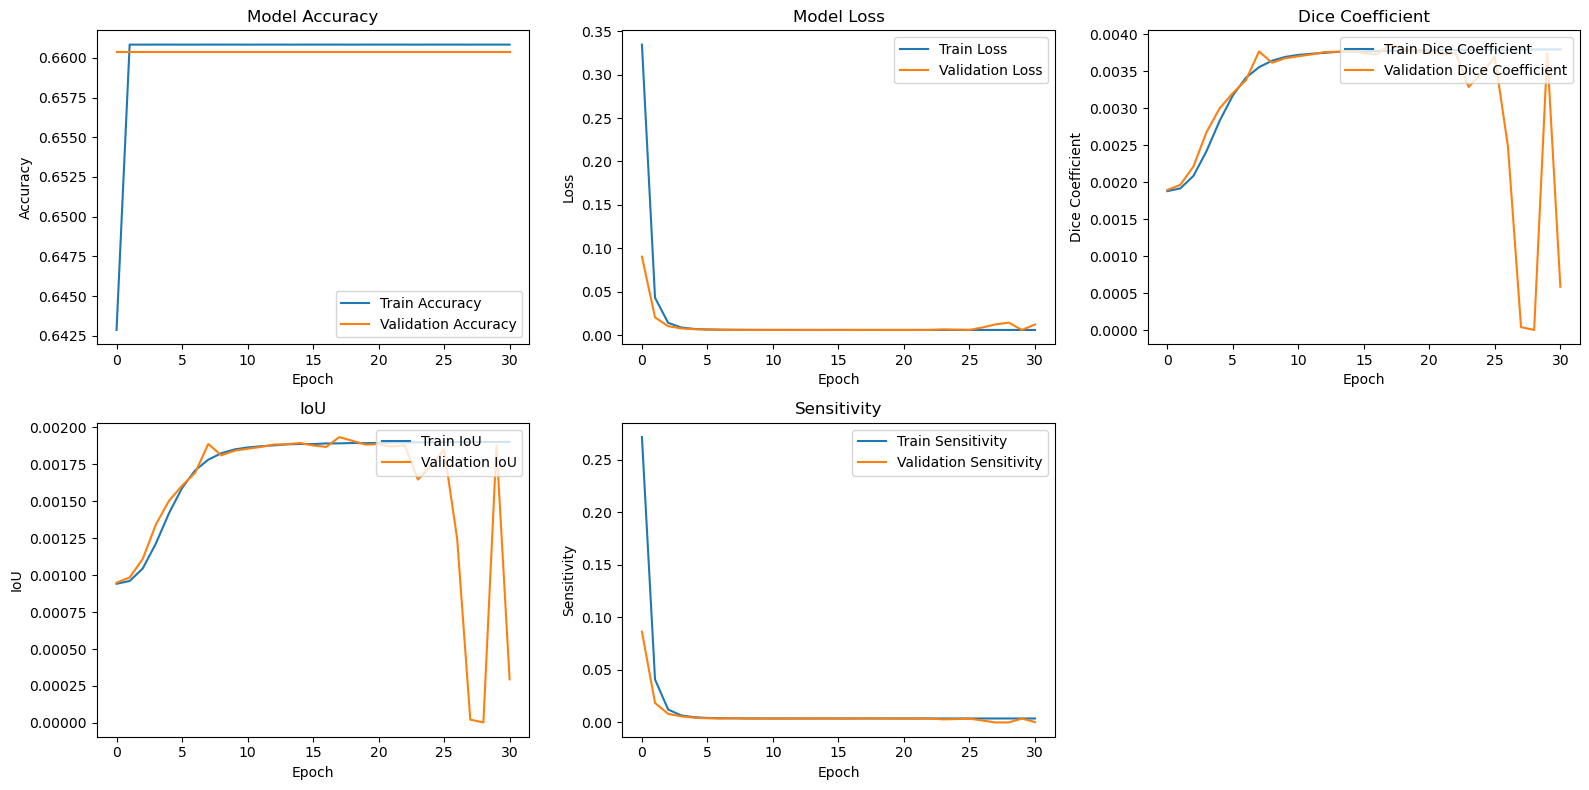

131/131 ━━━━━━━━━━━━━━━━━━━━ 540s 4s/step


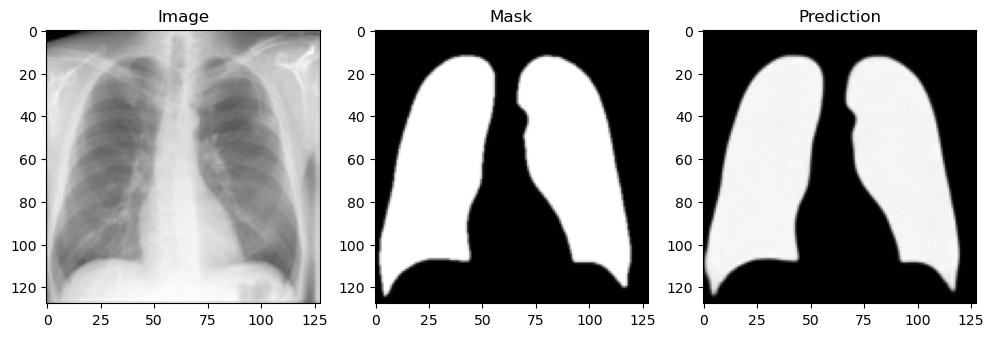

In [15]:
if __name__ == '__main__':
    main()